# Imports

In [2]:
import pandas as pd
from pathlib import Path
from sklearn.decomposition import PCA
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt 
from sklearn.preprocessing import StandardScaler
import datetime

import hdbscan

import os, math

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
# Preprocessing
from sklearn.preprocessing import MinMaxScaler
# Algorithms
from minisom import MiniSom
from tslearn.barycenters import dtw_barycenter_averaging
from tslearn.clustering import TimeSeriesKMeans, KernelKMeans, silhouette_score
from sklearn.cluster import KMeans, DBSCAN, SpectralClustering

# Loading Data

In [3]:
with open("IS-thesis-pattern-extraction/options.txt", 'r') as f:
    options = f.readlines()
    options = {option.split("=")[0]: option.split("=")[1].strip() for option in options}
print(options)

{'hanoi_scenario_dir': 'C:\\Users\\mjnst\\Desktop\\Thesis\\Hanoi_CMH\\Scenario-1', 'RUG_dir': 'C:\\Users\\mjnst\\Desktop\\Thesis\\RUG_data_5years', 'RUG_raw_csv': 'C:\\Users\\mjnst\\Desktop\\Thesis\\rug_csv.csv', 'RUG_timeseries': 'C:\\Users\\mjnst\\Desktop\\Thesis\\rug_timeseries.pkl', 'RUG_obfuscated': 'C:\\Users\\mjnst\\Desktop\\Thesis\\obfuscated_data.pkl'}


In [4]:
RUG = pd.read_pickle(options['RUG_obfuscated'])

# Preparing and Transforming Data

In [5]:
RUG.interpolate(method='linear', inplace=True, limit=20)

In [6]:
groups = RUG['Location 2 - consumption'].groupby(pd.Grouper(freq='D'))

# get the calender date of the groups
days = list(groups.first().index.strftime('%Y:%m:%d'))

gro = [groups.get_group(x).reset_index(drop=True) for x in groups.groups]

temp = pd.concat(gro, axis=1, keys=days)

temp.index = pd.date_range("00:00", "23:59", freq="1min").strftime('%H:%M')

# drop all columns of temp dataframe which contain nan values
temp.dropna(axis=1, how='any', inplace=True)

In [7]:
temp = temp[::10]

In [8]:
scaled_list = [temp[col] for col in temp]

for i in range(len(scaled_list)):
    scaler = MinMaxScaler()
    scaled_list[i] = MinMaxScaler().fit_transform(scaled_list[i].to_numpy().reshape(-1, 1))
    scaled_list[i]= scaled_list[i].reshape(len(scaled_list[i]))

scaled_list = np.nan_to_num(scaled_list, copy=False, nan=0.0)
scaled_list

array([[0.25483871, 0.25483871, 0.25483871, ..., 0.03225807, 0.03225807,
        0.03225807],
       [0.02797203, 0.02797203, 0.02797203, ..., 0.23776225, 0.23776225,
        0.23776225],
       [0.6072722 , 0.98147393, 1.        , ..., 0.02938414, 0.02938414,
        0.02938414],
       ...,
       [0.02      , 0.00333333, 0.06666667, ..., 0.06666667, 0.13666666,
        0.01666667],
       [0.14827585, 0.02413793, 0.02413793, ..., 0.20689656, 0.07586207,
        0.08965517],
       [0.0984127 , 0.17460318, 0.31746032, ..., 0.12698413, 0.00952381,
        0.02222222]])

# Principal Component Analysis

Shape before PCA:  (2128, 144)
Shape after PCA:  (2128, 7)


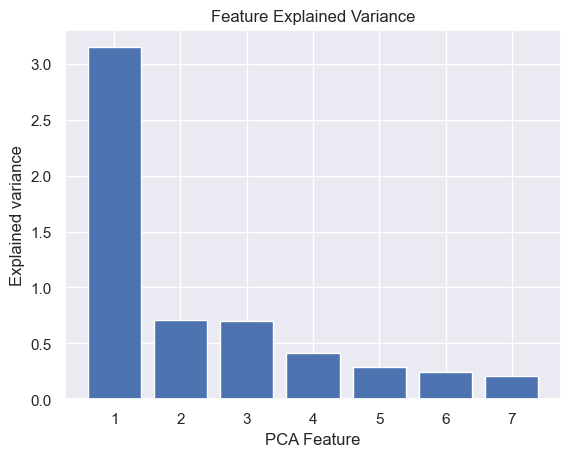

In [9]:
sns.set()
 
# Reduce from 4 to 3 features with PCA
# pca = PCA(n_components=cluster_count)
pca = PCA(n_components=7, svd_solver='full')
 
# Fit and transform data
pca_features = pca.fit_transform(scaled_list)
 

print('Shape before PCA: ', scaled_list.shape)
print('Shape after PCA: ', pca_features.shape)

pca_df = pd.DataFrame(
    data=pca_features)

# Bar plot of explained_variance
plt.bar(
    range(1,len(pca.explained_variance_)+1),
    pca.explained_variance_
    )
 
 
plt.xlabel('PCA Feature')
plt.ylabel('Explained variance')
plt.title('Feature Explained Variance')
plt.show()

# HDBSCAN

In [19]:
clusterer = hdbscan.HDBSCAN()

In [27]:
clusterer.fit(pca_features)

HDBSCAN()

In [28]:
clusterer.labels_

array([-1, -1, -1, ...,  4,  4,  4], dtype=int64)

In [29]:
clusterer.labels_.max()

4

In [30]:
import time
plot_kwds = {'alpha' : 0.25, 's' : 80, 'linewidths':0}
def plot_clusters(data, algorithm, args, kwds):
    start_time = time.time()
    labels = algorithm(*args, **kwds).fit_predict(data)
    end_time = time.time()
    palette = sns.color_palette('deep', np.unique(labels).max() + 1)
    colors = [palette[x] if x >= 0 else (0.0, 0.0, 0.0) for x in labels]
    plt.scatter(data.T[0], data.T[1], c=colors, **plot_kwds)
    frame = plt.gca()
    frame.axes.get_xaxis().set_visible(False)
    frame.axes.get_yaxis().set_visible(False)
    plt.title('Clusters found by {}'.format(str(algorithm.__name__)), fontsize=24)
    plt.text(-0.5, 0.7, 'Clustering took {:.2f} s'.format(end_time - start_time), fontsize=14)

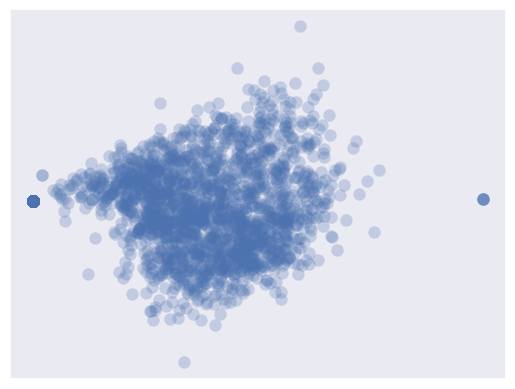

In [31]:
plt.scatter(pca_features.T[0], pca_features.T[1], c='b', **plot_kwds)
frame = plt.gca()
frame.axes.get_xaxis().set_visible(False)
frame.axes.get_yaxis().set_visible(False)

c:\Users\mjnst\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


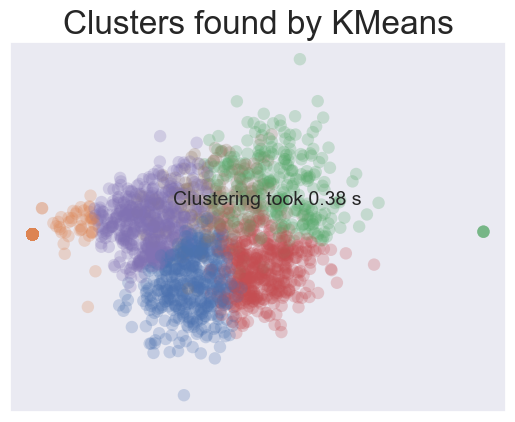

In [32]:
plot_clusters(pca_features, KMeans, (), {'n_clusters':6})

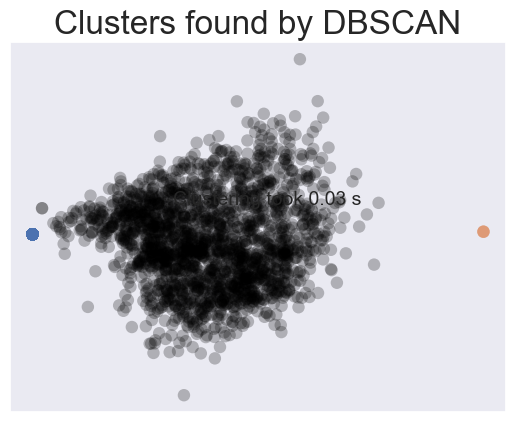

In [33]:
plot_clusters(pca_features, DBSCAN, (), {'eps':0.025})

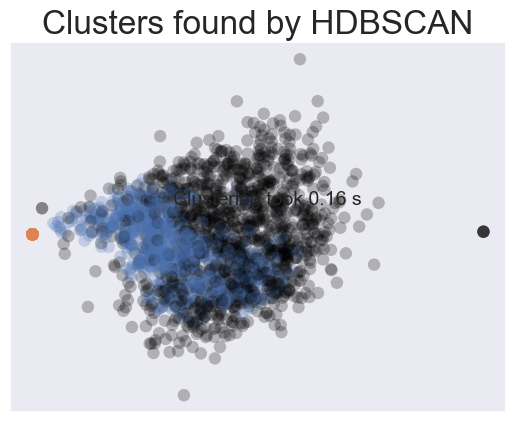

In [34]:
plot_clusters(pca_features, hdbscan.HDBSCAN, (), {'min_cluster_size':15})